In [1]:
# Import libraries
import os
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import fiona
from shapely.geometry import shape, mapping
from collections import OrderedDict
import itertools

# Setting for matplotlib figures export

In [3]:
# Export all illustration of each step in a folder
output_folder = 'Illustrations'
# Declare a list with path to illustrations plots
frames = []
# Setup a counter
i = 1

In [4]:
# Set a matplotlib color map 'darkgray' >< 'yellow'
cmap = mpl.colors.ListedColormap(['darkgray', 'yellow'])
# Set matplotlib figure size
fig_size = (10, 10)
# Set matplotlib resolution dpi
resol = 250
# For plot to appear in the notebook
%matplotlib inline 

In [5]:
# Set style preset parameters from Seaborn 
sns.set_style("darkgrid")
sns.set_context("paper")

# Functions for plotting maps

In [6]:
def single_plot_darkgray(gdf, inline=True):
    global i
    gdf.plot(color='darkgray', figsize=fig_size)
    output_plot = os.path.join(output_folder,"illustration_%s.png"%i)
    frames.append(output_plot)
    plt.savefig(output_plot, dpi=resol, bbox_inches='tight')
    i+=1
    if not inline: plt.close() # Prevent the plot to be displayed

In [7]:
def double_plot_yellow(gdf, smallest_unit_index, longest_neighbor, inline=False):
    global i
    tmp_plot_gdf = gdf.copy()
    tmp_plot_gdf['temp_color_plot']=[0 for index, unit in tmp_plot_gdf.iterrows() ]
    tmp_plot_gdf.at[smallest_unit_index, "temp_color_plot"] = 1
    tmp_plot_gdf.plot(cmap=cmap, column='temp_color_plot',  figsize=fig_size)
    output_plot = os.path.join(output_folder,"illustration_%s.png"%i)
    frames.append(output_plot)
    plt.savefig(output_plot, dpi=resol, bbox_inches='tight')
    if not inline: plt.close() # Prevent the plot to be displayed
    i+=1
    tmp_plot_gdf.at[longest_neighbor[smallest_unit_index], "temp_color_plot"] = 1
    tmp_plot_gdf.plot(cmap=cmap, column='temp_color_plot',  figsize=fig_size)
    output_plot = os.path.join(output_folder,"illustration_%s.png"%i)
    frames.append(output_plot)
    plt.savefig(output_plot, dpi=resol, bbox_inches='tight')
    if not inline: plt.close() # Prevent the plot to be displayed
    i+=1

# Import initial data

In [8]:
# Set the path to the original shapefile - Please adapt the path to your own data
path = "/home/tais/Bureau/temp/test_merge_smallpolu/test.shp"

In [9]:
# Read the shapefile
gdf = gpd.read_file(path)
# Keep only columns with population data (quantitative) that could be aggregated using a "grouby - sum" function
# Please adapt the column names according to your own data - Be carefull to keep the geometry column
gdf = gdf.loc[:,['geometry','CONCESSION','MENAGE', 'HOMME', 'FEMME', 'POPULATION']]
# Add a column with area (in hectares)
gdf['area'] = (gdf.geometry.area/10000).round(4)

In [10]:
# Add a new column 'dissolve_index' and fill it with the row index value 
gdf['dissolve_index']=[index for index, unit in gdf.iterrows() ]

In [11]:
# Display the attribute table
gdf.head()

,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,area,dissolve_index
0,"POLYGON ((243608.3332000002 1633592.527899999,...",36,53,223,232,455,5.7154,0
1,"POLYGON ((243825.0125000002 1633933.445499999,...",189,348,1530,1534,3064,8.7338,1
2,"POLYGON ((243989.9582000002 1633310.100199999,...",84,227,737,667,1403,2.8800,2
3,"POLYGON ((243914.1242000004 1634039.938300001,...",89,166,790,777,1567,2.4246,3
4,"POLYGON ((244076.5192 1633658.4285, 244100.121...",168,376,1320,1223,2544,6.3323,4


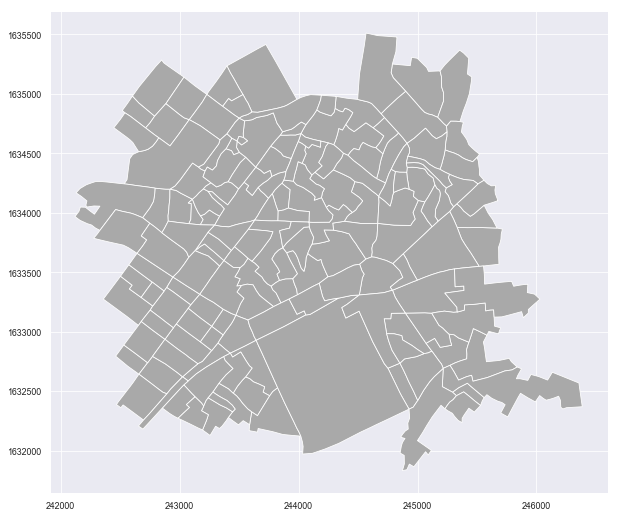

In [12]:
# Display + Save figure
single_plot_darkgray(gdf)

# Find the smallest polygon and its neighbors

In [13]:
## Define the threshold for the minimum area
thresh = 25000 # 2.5 ha

This function find the smaller unit and its neighbors and return them as a temporary shapefile (to be used in the next step).

In [14]:
# Declare a function that return a GeoDataframe with the smallest polygon and its neighbors
# 'gdf' is the name of the GeoDataframe to be used
# 'thresh_area' is the minimum desired area. Please consider using the standard area unit of the CRS of your data
# If the the area of the smallest polygon is bigger than the defined threshold 'thresh_area', the function return 'False'
def get_smallest_and_neighbors(gdf, thresh_area):
    neighbors=[]
    index_small = gdf.loc[gdf.geometry.area<thresh_area].index #
    small_count = len(index_small)
    if  small_count < 1:
        return 0, 0, 0
    else: 
        minarea = min(gdf.loc[index_small].geometry.area)  #
        smallest_unit_index = gdf.loc[gdf.geometry.area == minarea].index
        for index, unit in gdf.iterrows():
            if index == smallest_unit_index:  # Check for neighbors only for the smallest polygon
                # get 'not disjoint' countries
                neighbors = gdf[~gdf.geometry.disjoint(unit.geometry)].index.tolist()      
        return small_count, smallest_unit_index.tolist()[0], gdf.loc[neighbors]

In [15]:
# Get a dataframe with the smallest polygon and its neighborhing polygons
small_count, smallest_unit_index, gdf_small = get_smallest_and_neighbors(gdf, thresh)
# 'small_count' variable contain the number of polygons smaller thant the threshold
if small_count == 0:
    print "There is no polygons that are too small."
else:
    print "There remains %s polygons that are too small."%small_count

There remains 21 polygons that are too small.


In [16]:
# Print temporary dataframe with the smallest polygon and its neighbors
gdf_small

,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,area,dissolve_index
9,"POLYGON ((244396.8174000001 1634743.790200001,...",379,590,3043,2881,5924,7.5862,9
15,"POLYGON ((244186.6261 1634602.608200001, 24418...",52,73,355,392,746,1.1221,15
36,"POLYGON ((243478.1535999998 1634548.205800001,...",405,632,2726,2605,5331,9.7219,36
47,"POLYGON ((243997.2231000001 1634598.592399999,...",130,240,940,952,1892,3.0242,47
49,"POLYGON ((244062.0073999995 1634741.725400001,...",66,97,420,458,878,1.1122,49
63,"POLYGON ((244191.7148000002 1634988.2993, 2441...",297,527,1925,1993,3918,8.5293,63


# Find the neighbor sharing the longest border

## Convert GeoDataframe of polygon in FIONA collection

https://gist.github.com/nishadhka/97b06c21235f57552b5e471b5b6480a8

In [17]:
def convert_geodf_polygons_to_fiona(gdf):
    """Function that convert a Geodataframe into a FIONA 'Collection'"""
    def extract_polygon_geom(index,row):
        """Function that get the definition of the current dataframe row in FIONA format"""
        geom = mapping(row['geometry'])['coordinates']
        properties = zip(row[column_name].index,row[column_name])
        return {'geometry':{'coordinates': geom,'type': 'Polygon'},
                 'id':index,
                 'properties':OrderedDict(properties),
                'type': 'Feature'}

    attrib=gdf.loc[:, gdf.columns != 'geometry']
    column_name=attrib.columns
    polypd=[]
    for index, row in gdf.iterrows():
        ee=extract_polygon_geom(index,row)
        polypd.append(ee)
    return polypd

In [18]:
# Get FIONA collection format
polys = convert_geodf_polygons_to_fiona(gdf_small)

## Find the neighbor sharing the longest border with FIONA

https://gis.stackexchange.com/questions/197652/find-common-borders-of-features-and-get-their-attributes-using-fiona-and-shapely

In [19]:
def get_longest_border_index(fiona_polygon_collection, smallest_unit_index):
    """Function that return a dictionary with index of polygons as KEY 
    and index of the neighbor sharing the longest border as VALUE
    """
    id_dict={}
    max_length_dict={}

    for pol1,pol2 in  itertools.combinations(fiona_polygon_collection, 2):  # Get all possible combination of geometries
        geompol1 = shape(pol1['geometry'])
        geompol2 = shape(pol2['geometry'])
        if geompol1.touches(geompol2):  # Only if polygons touch each other
            id1 = pol1['id']
            id2 = pol2['id']
            if smallest_unit_index in [id1, id2]:
                try : 
                    length = shape(mapping(geompol1.intersection(geompol2))).length  # Get the lenght of the intersection (line)
                except: 
                    length = 0  # If intersection failed => Not a line (point) so lenght=0
                # Initialisation of the key is first time appearing in the loop
                if id1 not in id_dict.keys():   
                    id_dict[id1]=id2
                    max_length_dict[id1]=length
                if id2 not in id_dict.keys():   
                    id_dict[id2]=id1
                    max_length_dict[id2]=length
                # Update the VALUE of dictionary if the lenght is bigger than the current longest known in the dictionnary
                if length > max_length_dict[id1]:  
                    id_dict[id1]=id2
                    max_length_dict[id1]=length
                if length > max_length_dict[id2]:  
                    id_dict[id2]=id1
                    max_length_dict[id2]=length
    return id_dict

In [20]:
# Get a dictionnary with neighbors index
longest_neighbor = get_longest_border_index(polys, smallest_unit_index)

In [21]:
for index in longest_neighbor.keys():
    print "Entity at index ",index," shares its longest border with entity at index ",longest_neighbor[index]

Entity at index  36  shares its longest border with entity at index  49
Entity at index  9  shares its longest border with entity at index  49
Entity at index  15  shares its longest border with entity at index  49
Entity at index  49  shares its longest border with entity at index  63
Entity at index  47  shares its longest border with entity at index  49
Entity at index  63  shares its longest border with entity at index  49


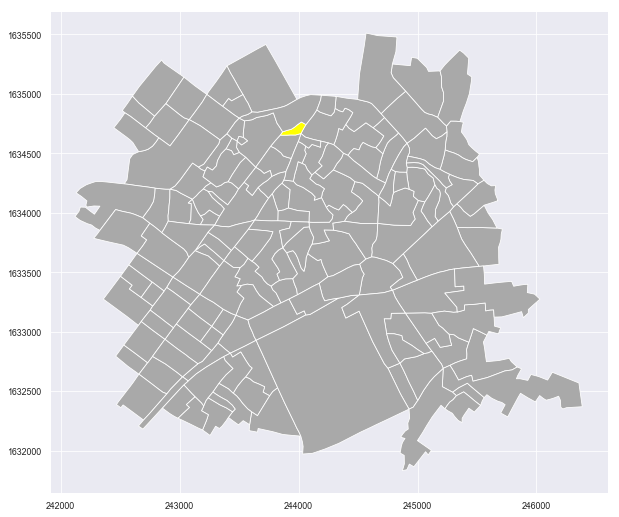

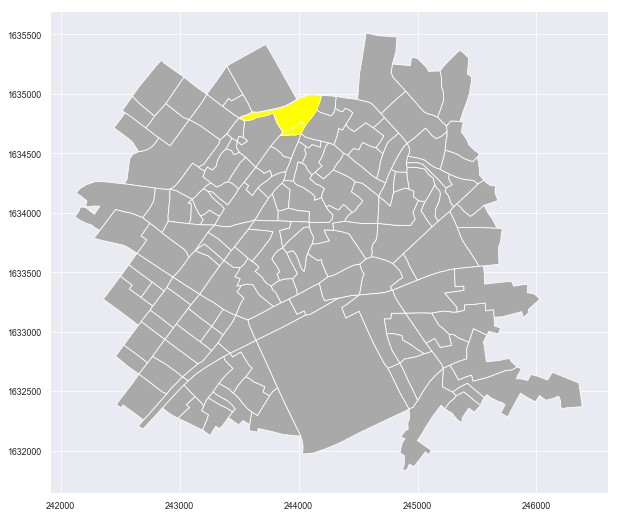

In [22]:
# Display + Save figure
double_plot_yellow(gdf, smallest_unit_index, longest_neighbor, inline=True)

## Update the initial dataframe

In [23]:
## Update "dissolve_index" column of the smallest polygon 
gdf.at[smallest_unit_index, "dissolve_index"] = int(longest_neighbor[smallest_unit_index])

## Dissolve polygons with same 'dissolve_index'

In [24]:
def dissolve_admin(gdf, dissolve_column, aggfunc='sum'):
    # Use dissolve function of Geopandas
    tmp = gdf.dissolve(by=dissolve_column, aggfunc=aggfunc, as_index=False)
    # Reset the column 'dissolve_index' with the nwe index of the table 
    tmp['dissolve_index']=[index for index, unit in tmp.iterrows() ]
    return tmp

In [25]:
# Dissolve according to 'dissolve_index' column
gdf = dissolve_admin(gdf, dissolve_column='dissolve_index', aggfunc='sum')
# Display the attribute table
gdf.head()

,dissolve_index,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,area
0,0,"POLYGON ((243608.3332000002 1633592.527899999,...",36,53,223,232,455,5.7154
1,1,"POLYGON ((243825.0125000002 1633933.445499999,...",189,348,1530,1534,3064,8.7338
2,2,"POLYGON ((243989.9582000002 1633310.100199999,...",84,227,737,667,1403,2.8800
3,3,"POLYGON ((243914.1242000004 1634039.938300001,...",89,166,790,777,1567,2.4246
4,4,"POLYGON ((244076.5192 1633658.4285, 244100.121...",168,376,1320,1223,2544,6.3323


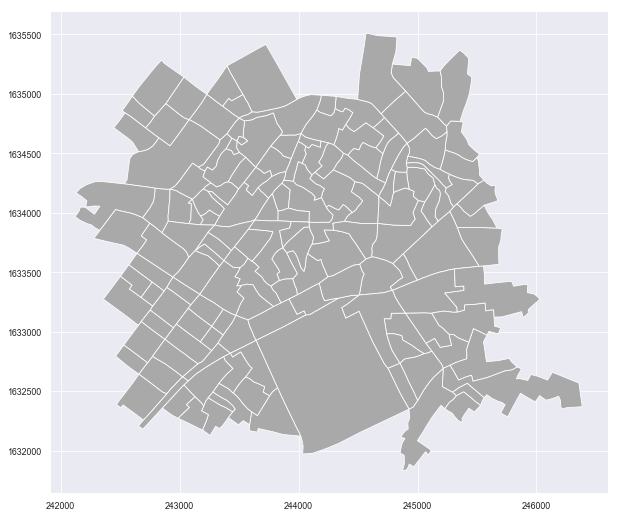

In [26]:
# Display + Save figure
single_plot_darkgray(gdf)

# Execute again until there is no more small polygons

In [27]:
# Get a dataframe with the smallest polygon and its neighborhing polygons
small_count, smallest_unit_index, gdf_small = get_smallest_and_neighbors(gdf, thresh)

# While loop
if small_count == 0:
    print "There is no polygons that are too small."
else:   
    while small_count > 0:
        print "There remains %s polygons that are too small."%small_count
        # Get FIONA collection format
        polys = convert_geodf_polygons_to_fiona(gdf_small)
        # Get a dictionnary with neighbors index
        longest_neighbor = get_longest_border_index(polys, smallest_unit_index)
        # Display + Save figure
        double_plot_yellow(gdf, smallest_unit_index, longest_neighbor, inline=False)
        ## Update "dissolve_index" column of the smallest polygon 
        gdf.at[smallest_unit_index, "dissolve_index"] = int(longest_neighbor[smallest_unit_index])
        # Dissolve according to 'dissolve_index' column
        gdf = dissolve_admin(gdf, dissolve_column='dissolve_index', aggfunc='sum')
        # Display + Save figure
        single_plot_darkgray(gdf, inline=False)
        # Get a dataframe with the smallest polygon and its neighborhing polygons
        small_count, smallest_unit_index, gdf_small = get_smallest_and_neighbors(gdf, thresh)

There remains 20 polygons that are too small.
There remains 19 polygons that are too small.
There remains 18 polygons that are too small.
There remains 17 polygons that are too small.
There remains 16 polygons that are too small.
There remains 15 polygons that are too small.
There remains 14 polygons that are too small.
There remains 13 polygons that are too small.
There remains 11 polygons that are too small.
There remains 10 polygons that are too small.
There remains 9 polygons that are too small.
There remains 8 polygons that are too small.
There remains 7 polygons that are too small.
There remains 6 polygons that are too small.
There remains 5 polygons that are too small.
There remains 4 polygons that are too small.
There remains 3 polygons that are too small.
There remains 2 polygons that are too small.
There remains 1 polygons that are too small.


# Export result

### Export final result as shapefile

In [28]:
# Set the path to the shapefile to be created
shape_export = '/home/tais/Bureau/temp/test_merge_smallpolu/test_minsize.shp'
# Export
gdf.to_file(driver='ESRI Shapefile',filename=shape_export)

## Create a gif from all plots

To use this functionnality, pleae first install [imageio](https://github.com/imageio/imageio).

In [29]:
import imageio
import glob
from PIL import Image
from numpy import array
imagestack = []
for frame in frames:
    img = Image.open(frame)
    arr = array(img)
    imagestack.append(arr)
imageio.mimsave(os.path.join(output_folder,"illustration.gif"), imagestack, fps=3)

## Delete the individual plots files

In [30]:
for frame in frames:
    os.remove(frame)